## Berechnung einer Kanalströmung

Wieder lösen wir alle drei Differentialgleichungen, die wir zur Berechnung einer  instationären, zweidimensionalen, inkompressiblen Strömung benötigen. Der einzige Unterschied ist, dass wir in der Impulsgleichung für die $x$-Richtung einen Quellterm hinzufügen (eine Volumenkraft, ähnlich der Gravitation), die für den Antrieb der Strömung sorgt.

Nochmal ins Gedächtnis gerufen lauten die Gleichungen:

Impulsgleichung:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) + F $$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) $$

Druckgleichung (Poisson-Gleichung) als Ersatz für die Kontinuitätsgleichung:

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right) + \rho\frac{\partial}{\partial t}\left(\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y} \right)$$



Die diskretisierten Gleichungen sind identisch zu denen der Kavität. Bei den Randebingungen fügen wir nun jedoch periodische Randbedingungen am Ein- und Austritt des Kanals hinzu, um en unendlich langes Rohr zu simulieren.

### Implementierung in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [9]:
nx = 51
ny = 51
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu  = .1
dt  = .001
F   = 1

Den langen Term auf der rechten Seite der Poisson-Gleichung fassen wir in einer Funktion zusammen, um nicht den Überblick zu verlieren. Beachten Sie die Implementierung der periodischen Randbedingungen.

In [10]:
def poisson_rhs(b, rho, dt, u, v, dx, dy):

    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    # Periodische Randbedingung am Ausströmrand
    b[1:-1, -1] = (rho * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                          2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

    # Periodische Randbedingung am Einströmrand
    b[1:-1, 0] = (rho * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                         2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))
    
    return b

In einer weitere Funktion packen wir die Lösung der Poisson-Gleichung. Diese muss nach jedem Zeitschritt gelöst werden, um ein Druckfeld zu finden, das zur Erfüllung der Divergenzfreiheit führt. Auch hier müssen die periodischen Randbedingungen hinzugefügt werden.

In [11]:
def solve_poisson(p, dx, dy, b, nit):
    pn = p.copy()
    #pn = numpy.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Periodische Randbedingung am Ausströmrand
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Periodische Randbedingung am Einströmrand
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Zero Gradient Randbedingung an den Wänden
        p[-1, :] =p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
    
    return p

Die Lösung der restlichen Gleichungen fassen wir ebenfalls in einer Funktion zusammen:

In [12]:
def channel(nt, nit, u, v, dt, dx, dy, p, rho, nu):
    #un = u.copy()
    #vn = v.copy()
    b = np.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = poisson_rhs(b, rho, dt, u, v, dx, dy)
        p = solve_poisson(p, dx, dy, b, nit)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx * 
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy * 
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * 
                        (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 * 
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                         F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx * 
                        (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy * 
                        (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                         dt / (2 * rho * dy) * 
                        (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                         nu * (dt / dx**2 *
                        (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                         dt / dy**2 * 
                        (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Periodische Randbedingung am Ausströmrand     
        u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                      (un[1:-1, -1] - un[1:-1, -2]) -
                       vn[1:-1, -1] * dt / dy * 
                      (un[1:-1, -1] - un[0:-2, -1]) -
                       dt / (2 * rho * dx) *
                      (p[1:-1, 0] - p[1:-1, -2]) + 
                       nu * (dt / dx**2 * 
                      (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                       dt / dy**2 * 
                      (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

        # Periodische Randbedingung am Einströmrand
        u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                     (un[1:-1, 0] - un[1:-1, -1]) -
                      vn[1:-1, 0] * dt / dy * 
                     (un[1:-1, 0] - un[0:-2, 0]) - 
                      dt / (2 * rho * dx) * 
                     (p[1:-1, 1] - p[1:-1, -1]) + 
                      nu * (dt / dx**2 * 
                     (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                      dt / dy**2 *
                     (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

        # Periodische Randbedingung am Ausströmrand
        v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                      (vn[1:-1, -1] - vn[1:-1, -2]) - 
                       vn[1:-1, -1] * dt / dy *
                      (vn[1:-1, -1] - vn[0:-2, -1]) -
                       dt / (2 * rho * dy) * 
                      (p[2:, -1] - p[0:-2, -1]) +
                       nu * (dt / dx**2 *
                      (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                       dt / dy**2 *
                      (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

        # Periodische Randbedingung am Einströmrand
        v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                     (vn[1:-1, 0] - vn[1:-1, -1]) -
                      vn[1:-1, 0] * dt / dy *
                     (vn[1:-1, 0] - vn[0:-2, 0]) -
                      dt / (2 * rho * dy) * 
                     (p[2:, 0] - p[0:-2, 0]) +
                      nu * (dt / dx**2 * 
                     (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                      dt / dy**2 * 
                     (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))


        # Wandrandbedingung: u,v = 0 @ y = 0,2
        u[0, :] = 0
        u[-1, :] = 0
        v[0, :] = 0
        v[-1, :]=0


    return u, v, p

Und schon sind wir fertig und können unsere Rechnung starten. Wir setzen die Anfangsbedingungen und berechnen zunächst 500 Zeitschritte (mit jeweils 50 sog *inneren Iterationen* für die Poisson-Gleichung):

In [13]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
nt = 500
nit = 50
u, v, p = channel(nt, nit, u, v, dt, dx, dy, p, rho, nu)

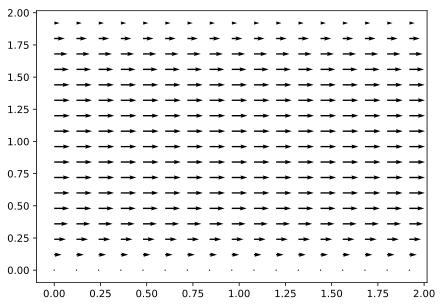

In [14]:
fig = plt.figure(figsize = (7,5))
plt.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3]);


---
Dieses Notebook folgt einer Idee von Lorena A. Barba und deren exzellenter Ausarbeitung in Python (["12 Steps to Navier Stokes"](http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/)).

Der folgende Python-Code darf ignoriert werden. Er dient nur dazu, die richtige Formatvorlage für die Jupyter-Notebooks zu laden.

In [8]:
from IPython.core.display import HTML
def css_styling():
    styles = open('TFDStyle.css', 'r').read()
    return HTML(styles)
css_styling()